In [1]:
#imports 
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import json
from sentence_transformers import SentenceTransformer
from sklearn.manifold import TSNE
import os

/home/guillaumelevy/Documents/WorldLLM/.venv/lib/python3.10/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


In [2]:
#Load the data
print("-------------------------------- Load IS --------------------------------")
experiment_ext = ""
name_experiment_is = "playground_is_phi_phi" + experiment_ext
path_start = "./outputs/" + name_experiment_is + "/"
lst_data_is = []
for f_day in os.listdir(path_start):
    if os.path.isdir(path_start + f_day):
        for f_hour in os.listdir(path_start + f_day):
            if os.path.isdir(path_start + f_day + "/" + f_hour):
                path = path_start + f_day + "/" + f_hour + "/all.json"
                with open(path, "r") as file:
                    lst_data_is.append(json.load(file))
                    print("Loaded: " + path)
print("-------------------------------- Load MH --------------------------------")
name_experiment_mh = "/playground_metropolis_phi_phi"
path_start = "./outputs/" + name_experiment_mh + "/"
lst_data_mh = []             
for f_day in os.listdir(path_start):
    if os.path.isdir(path_start + f_day):
        for f_hour in os.listdir(path_start + f_day):
            if os.path.isdir(path_start + f_day + "/" + f_hour):
                path = path_start + f_day + "/" + f_hour + "/all.json"
                with open(path, "r") as file:
                    lst_data_mh.append(json.load(file))
                    print("Loaded: " + path)

-------------------------------- Load IS --------------------------------
Loaded: ./outputs/playground_is_phi_phi/2024-09-11/17-00-12_442/all.json
Loaded: ./outputs/playground_is_phi_phi/2024-09-11/17-30-45_443/all.json
Loaded: ./outputs/playground_is_phi_phi/2024-09-11/16-54-54_439/all.json
Loaded: ./outputs/playground_is_phi_phi/2024-09-11/16-56-58_441/all.json
Loaded: ./outputs/playground_is_phi_phi/2024-09-11/16-55-34_440/all.json
Loaded: ./outputs/playground_is_phi_phi/2024-09-11/16-51-41_438/all.json
-------------------------------- Load MH --------------------------------
Loaded: ./outputs//playground_metropolis_phi_phi/2024-09-11/17-52-38_439/all.json
Loaded: ./outputs//playground_metropolis_phi_phi/2024-09-11/17-52-38_438/all.json


In [3]:
# For fair comparison it is better to compare with the same true rule
true_rule = lst_data_mh[0]["true_rule"]
for data in lst_data_mh + lst_data_is:
    assert data["true_rule"] == true_rule
    print(len(data["rules"]))

603
603
201
201
201
201
201
201


In [4]:
# Reconstruct all rules IS
all_rules_is = []
all_likelihoods_is = []
all_weights_is = []
for data in lst_data_is:
    all_rules_is.append(np.repeat(data["rules"], data["metrics"]["counts"]))
    all_likelihoods_is.append(np.repeat(data["likelihoods"], data["metrics"]["counts"]))
    all_weights_is.append(np.repeat(data["metrics"]["weights"], data["metrics"]["counts"]))
all_rules_is = np.stack(all_rules_is)
all_likelihoods_is = np.stack(all_likelihoods_is)
all_weights_is = np.stack(all_weights_is)

In [5]:
# Reconstruct all rules MH
all_rules_mh = []
all_likelihoods_mh = []
all_weights_mh = []
all_prev_rules_ind_mh = []
for data in lst_data_mh:
    nb_particles = data["metrics"]["nb_particles"]
    rules = np.array(data["rules"])
    likelihoods = np.array(data["likelihoods"])
    weights =  np.array(data["metrics"]["weights"])
    prev_rules_ind = np.array(data["metrics"]["prev_rules_ind"])
    all_rules_mh.append(rules.reshape((-1, nb_particles)).transpose())
    all_likelihoods_mh.append(likelihoods.reshape((-1, nb_particles)).transpose())
    all_weights_mh.append(weights.reshape((-1, nb_particles)).transpose())
    all_prev_rules_ind_mh.append(prev_rules_ind.reshape((-1, nb_particles)).transpose())
# Concatenate all seeds
all_rules_mh = np.concatenate(all_rules_mh, axis=0)
all_likelihoods_mh = np.concatenate(all_likelihoods_mh, axis=0)
all_weights_mh = np.concatenate(all_weights_mh, axis=0)
all_prev_rules_ind_mh = np.concatenate(all_prev_rules_ind_mh, axis=0)

In [40]:
# Get the likelihood without the rule for each seed in IS:
for i in range(len(all_rules_is)):
    assert (all_rules_is[i][-1]) is None
    print(f"For seed {i} the likelihood without the rule is {all_likelihoods_is[i][-1]}")

For seed 0 the likelihood without the rule is -504.3806457519531
For seed 1 the likelihood without the rule is -521.8727416992188
For seed 2 the likelihood without the rule is -504.83551025390625
For seed 3 the likelihood without the rule is -505.5602722167969
For seed 4 the likelihood without the rule is -535.6123046875
For seed 5 the likelihood without the rule is -490.388427734375


In [6]:
# Compare best rule for IS and MH
# Best rules of each method
best_taken = 50
best_rules_ind_mh = np.argsort(-all_likelihoods_mh.flatten())[:best_taken]
best_rules_ind_is = np.argsort(-all_likelihoods_is.flatten())[:best_taken]
all_likelihoods = np.concatenate([all_likelihoods_mh.flatten()[best_rules_ind_mh], all_likelihoods_is.flatten()[best_rules_ind_is]])
all_rules = np.concatenate([all_rules_mh.flatten()[best_rules_ind_mh], all_rules_is.flatten()[best_rules_ind_is]])
indices = np.argsort(-all_likelihoods)
print(f"Best rules for MH in red and for IS in green")
for incr, ind in enumerate(indices):
    if ind < best_taken:
        color_start = "\x1b[31m"
        color_end = "\x1b[0m"
    else:
        color_start = "\033[92m"
        color_end = "\033[0m"
    print(
        f"{color_start}-----rule-----:{incr}: {repr(all_rules[ind])}, likelihood: {all_likelihoods[ind]:2f}{color_end}"
    )

Best rules for MH in red and for IS in green
-----rule-----:0: '1. When any plant or animal seed is watered, it turns into the respective product (berry, pea, carrot, potato, beet).\n2. You can hold (water) and (product), but not multiple (products).\n3. To grow an animal (pig, elephant, giraffe), a (baby version) of that animal is needed.\n4. All (baby animals and plants) grow into (adult versions) when the respective object (seed or baby) is held.', likelihood: -312.683960
-----rule-----:1: "1. Objects grow when 'You give the water'.\n2. An object can only exist if it is grown at least once.\n3. Any object can transform into another object if transformed by 'You give the water'.\n4. An object can only be grown once and then ceases to exist.\n5. Animals grow into rhinoceros, elephant, giraffe, pig and hoofed animals when having 'you give all the objects you hold', including the water.", likelihood: -326.406372
-----rule-----:2: '1. Animals on the island grow from their "baby" form to 

In [7]:
# Number of sames rules per particle
lst_nb_redundant_rules_mh = []
for particle in all_rules_mh:
    lst_nb_redundant_rules_mh.append(len(particle) - len(set(particle)))
lst_nb_redundant_rules_is = []
for particle in all_rules_is:
    lst_nb_redundant_rules_is.append(len(particle) - len(set(particle))
)
print("Redundant rules per particle for MH: ", lst_nb_redundant_rules_mh)
print("Redundant rules per particle for IS: ", lst_nb_redundant_rules_is)

Redundant rules per particle for MH:  [0, 4, 0, 0, 0, 0]
Redundant rules per particle for IS:  [0, 0, 0, 0, 0, 0]


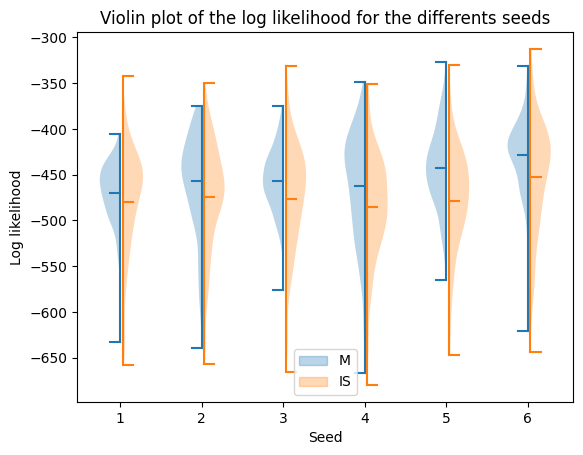

In [8]:
# Plot violin plot of the log likelihood as a function of the seeds for both algorithms
plt.figure()
color_mh = plt.violinplot(all_likelihoods_mh.transpose(), showmeans=True, side = "low")["bodies"][0].get_facecolor().flatten()
color_mh = matplotlib.patches.Patch(color=color_mh)
color_is = plt.violinplot(all_likelihoods_is.transpose(), showmeans=True, side="high", positions=[i+1.03 for i in range(len(all_likelihoods_is))])["bodies"][0].get_facecolor().flatten()
color_is = matplotlib.patches.Patch(color=color_is)
plt.legend([color_mh, color_is], ["M", "IS"])
plt.title("Violin plot of the log likelihood for the differents seeds")
plt.xlabel("Seed")
plt.ylabel("Log likelihood")
plt.show()

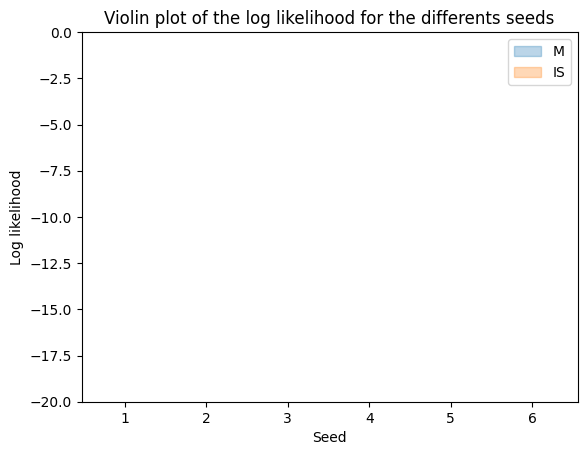

In [9]:
# Plot violin plot of the log likelihood as a function of the seeds for both algorithms
fig,ax = plt.subplots()
color_mh = plt.violinplot(all_likelihoods_mh.transpose(), showmeans=True, side = "low")["bodies"][0].get_facecolor().flatten()
color_mh = matplotlib.patches.Patch(color=color_mh)
color_is = plt.violinplot(all_likelihoods_is.transpose(), showmeans=True, side="high", positions=[i+1.03 for i in range(len(all_likelihoods_is))])["bodies"][0].get_facecolor().flatten()
color_is = matplotlib.patches.Patch(color=color_is)
ax.set_ylim(-20,0)
plt.legend([color_mh, color_is], ["M", "IS"])
plt.title("Violin plot of the log likelihood for the differents seeds")
plt.xlabel("Seed")
plt.ylabel("Log likelihood")
plt.show()

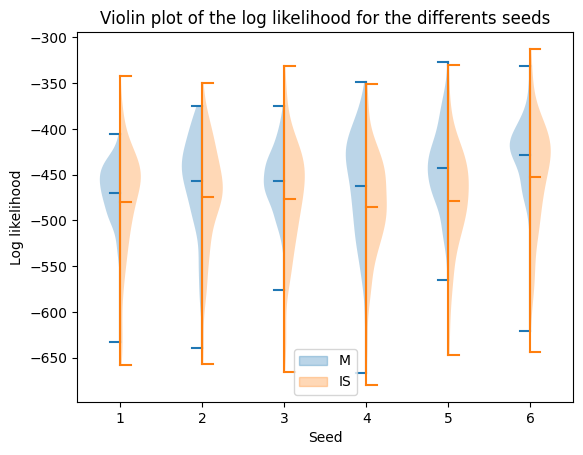

In [10]:
# Plot violin plot of the log likelihood as a function of the seeds for both algorithms for high likelihoods
min_likelihood=-np.inf
high_likelihoods_mh = [all_likelihoods_mh[row][all_likelihoods_mh[row] > min_likelihood] for row in range(len(all_likelihoods_mh))]
high_likelihoods_is = [all_likelihoods_is[row][all_likelihoods_is[row] > min_likelihood] for row in range(len(all_likelihoods_is))]
fig,ax = plt.subplots()
color_mh = plt.violinplot(high_likelihoods_mh, showmeans=True, side = "low")["bodies"][0].get_facecolor().flatten()
color_mh = matplotlib.patches.Patch(color=color_mh)
color_is = plt.violinplot(high_likelihoods_is, showmeans=True, side="high")["bodies"][0].get_facecolor().flatten()
color_is = matplotlib.patches.Patch(color=color_is)
plt.legend([color_mh, color_is], ["M", "IS"])
plt.title("Violin plot of the log likelihood for the differents seeds")
plt.xlabel("Seed")
plt.ylabel("Log likelihood")
plt.show()

# Embeddings

In [11]:
model = SentenceTransformer("all-mpnet-base-v2")
embeddings = model.encode(np.concatenate([all_rules_mh.flatten(), all_rules_is.flatten()], axis=0))

### t-SNE

In [35]:
#Compute the t-SNE embeddings
proj_embeddings = TSNE(n_components=2).fit_transform(embeddings)

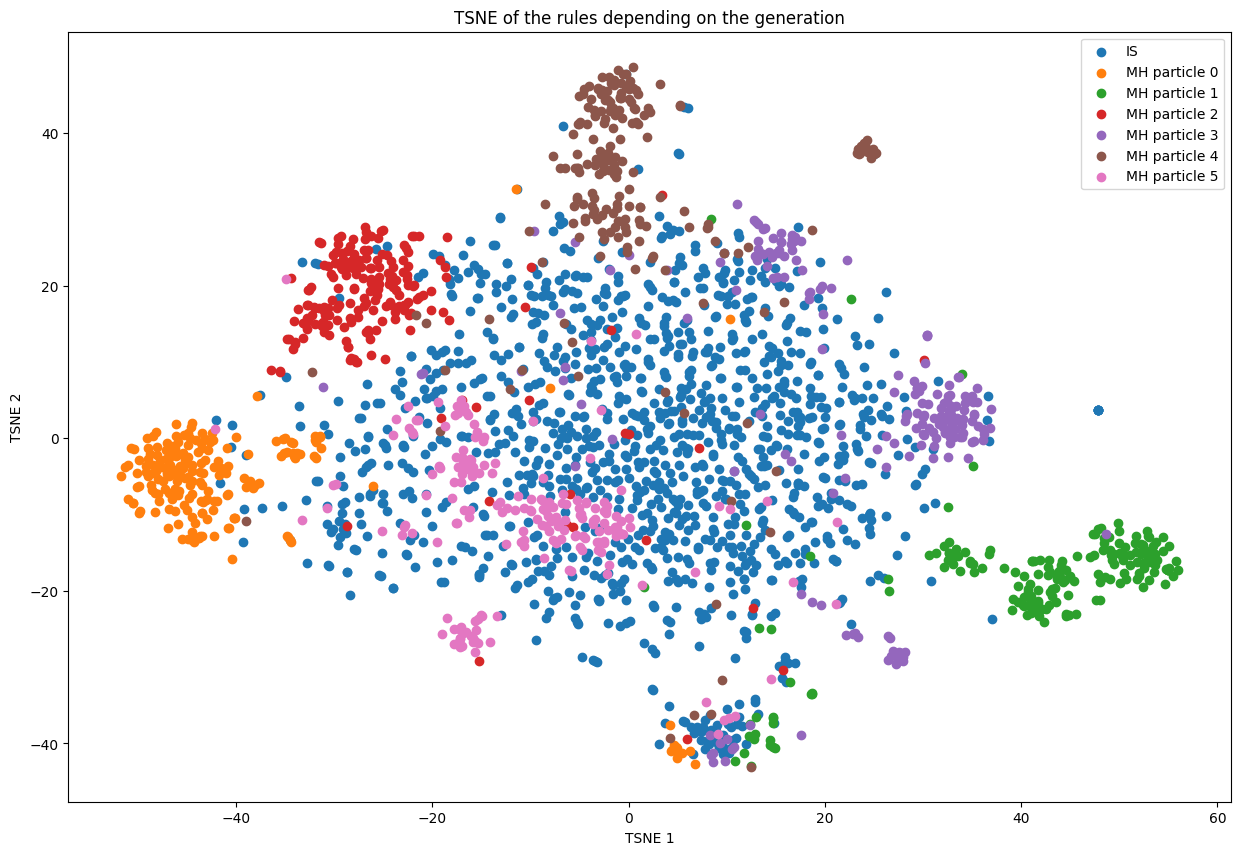

In [36]:
# Plot the embeddings
plt.figure(figsize=(15,10))
plt.scatter(proj_embeddings[len(all_rules_mh.flatten()):,0], proj_embeddings[len(all_rules_mh.flatten()):,1], label="IS")
#Plot MH particles
for i in range(all_rules_mh.shape[0]):
    plt.scatter(proj_embeddings[i*all_rules_mh.shape[1]: (i+1)*all_rules_mh.shape[1],0], proj_embeddings[i*all_rules_mh.shape[1]: (i+1)*all_rules_mh.shape[1],1], label="MH particle "+str(i))
plt.legend()
plt.xlabel("TSNE 1")
plt.ylabel("TSNE 2")
plt.title("TSNE of the rules depending on the generation")
plt.show()

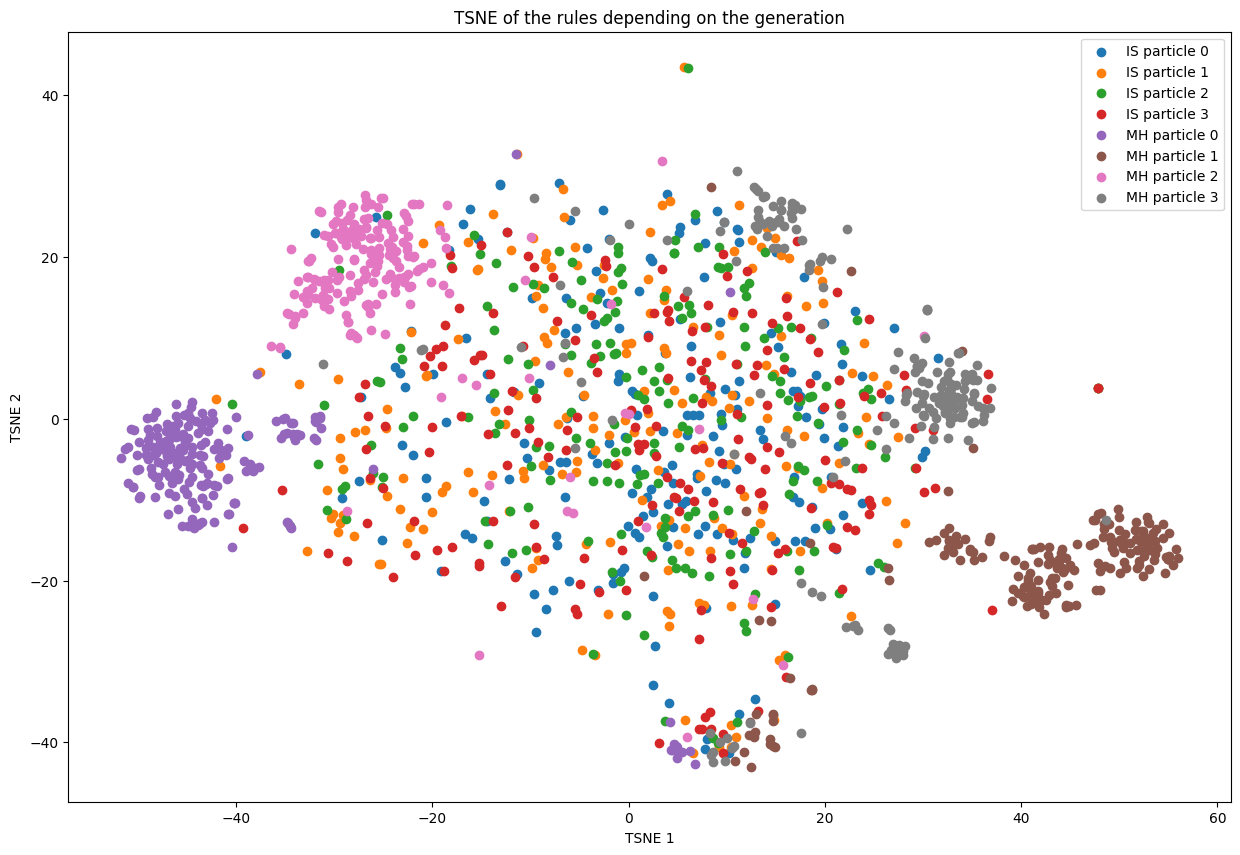

In [37]:
# Plot the embeddings
plt.figure(figsize=(15,10))
for i in range(4):
    plt.scatter(proj_embeddings[len(all_rules_mh.flatten()) +i*all_rules_is.shape[1]: len(all_rules_mh.flatten()) +(i+1)*all_rules_is.shape[1],0], proj_embeddings[len(all_rules_mh.flatten()) +i*all_rules_is.shape[1]: len(all_rules_mh.flatten()) +(i+1)*all_rules_is.shape[1],1], label="IS particle "+str(i))
# plt.scatter(proj_embeddings[len(all_rules_mh.flatten()):,0], proj_embeddings[len(all_rules_mh.flatten()):,1], label="IS")
#Plot MH particles
for i in range(4):
    plt.scatter(proj_embeddings[i*all_rules_mh.shape[1]: (i+1)*all_rules_mh.shape[1],0], proj_embeddings[i*all_rules_mh.shape[1]: (i+1)*all_rules_mh.shape[1],1], label="MH particle "+str(i))
plt.legend()
plt.xlabel("TSNE 1")
plt.ylabel("TSNE 2")
plt.title("TSNE of the rules depending on the generation")
plt.show()

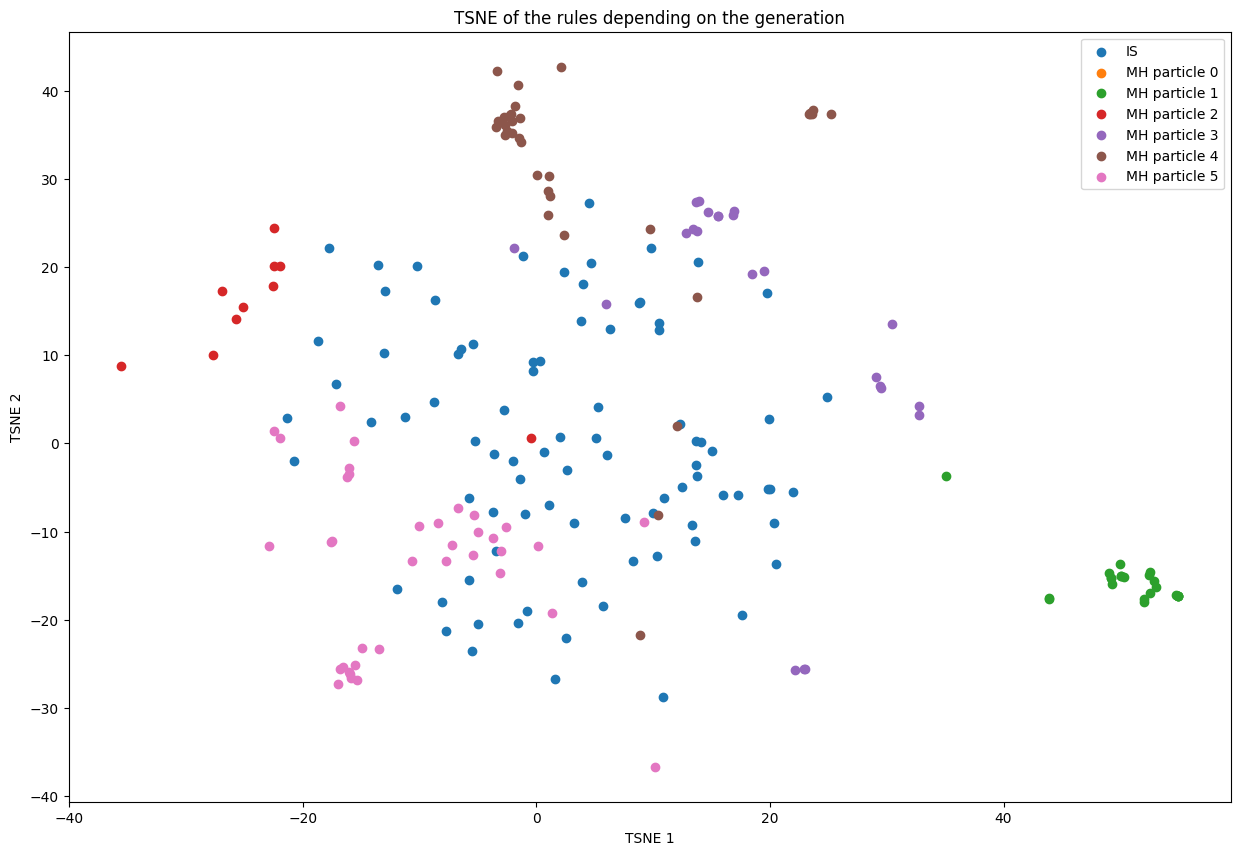

In [38]:
# Plot embeddings with likelihoods high enough
# Plot the embeddings
all_likelihoods = np.concatenate([all_likelihoods_mh.flatten(), all_likelihoods_is.flatten()])
mask_likelihood = all_likelihoods > -400
mask_is = np.arange(len(all_likelihoods)) >= len(all_rules_mh.flatten())
plt.figure(figsize=(15,10))
plt.scatter(proj_embeddings[mask_likelihood&mask_is,0], proj_embeddings[mask_likelihood&mask_is,1], label="IS")
#Plot MH particles
for i in range(len(all_rules_mh)):
    mask_mh = (np.arange(len(all_likelihoods)) < (i+1)*all_rules_mh.shape[1]) & (np.arange(len(all_likelihoods)) >= i*all_rules_mh.shape[1])
    plt.scatter(proj_embeddings[mask_likelihood&mask_mh,0], proj_embeddings[mask_likelihood&mask_mh,1], label="MH particle "+str(i))
plt.legend()
plt.xlabel("TSNE 1")
plt.ylabel("TSNE 2")
plt.title("TSNE of the rules depending on the generation")
plt.show()

### PCA

In [30]:
#Compute the PCA embeddings
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
proj_embeddings = pca.fit_transform(embeddings)

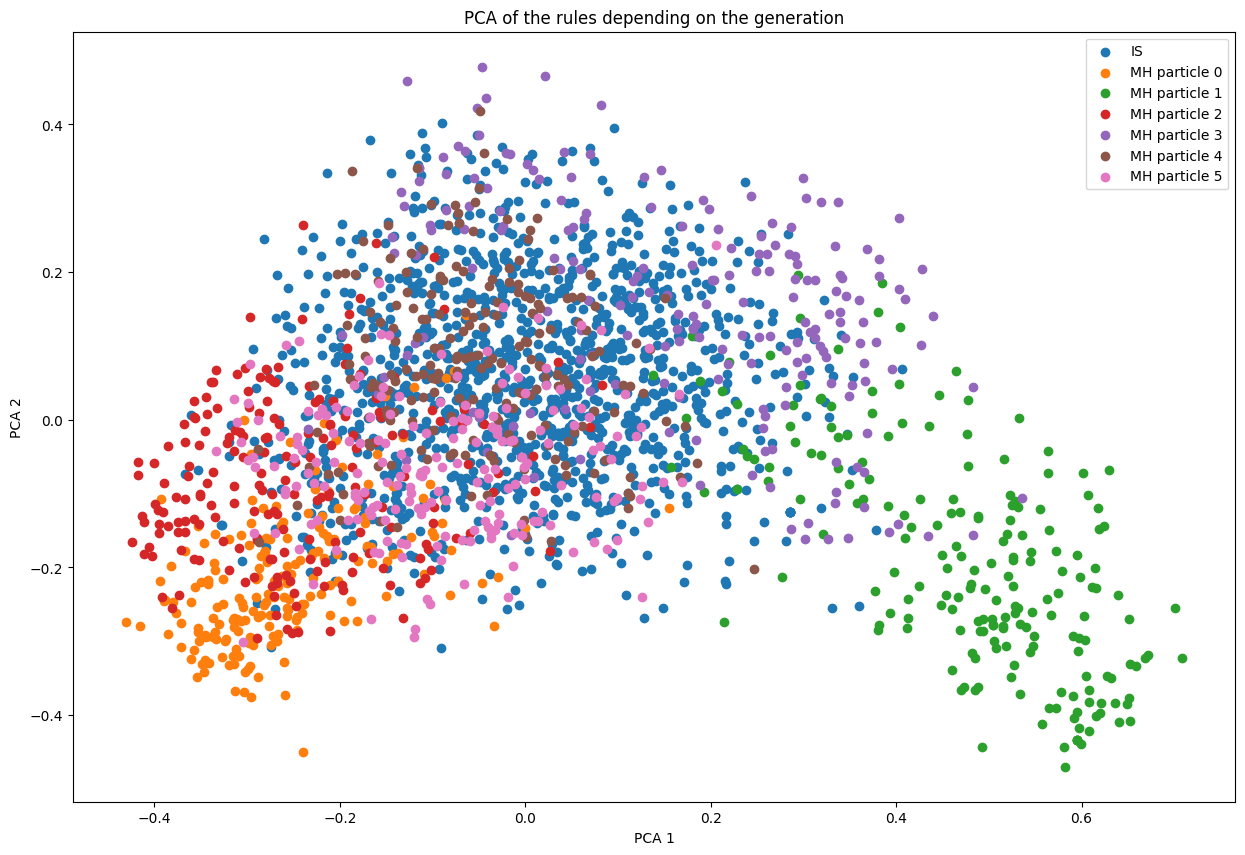

In [31]:
# Plot the embeddings
plt.figure(figsize=(15,10))
plt.scatter(proj_embeddings[len(all_rules_mh.flatten()):,0], proj_embeddings[len(all_rules_mh.flatten()):,1], label="IS")
#Plot MH particles
for i in range(len(all_rules_mh)):
    plt.scatter(proj_embeddings[i*all_rules_mh.shape[1]: (i+1)*all_rules_mh.shape[1],0], proj_embeddings[i*all_rules_mh.shape[1]: (i+1)*all_rules_mh.shape[1],1], label="MH particle "+str(i))
plt.legend()
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("PCA of the rules depending on the generation")
plt.show()

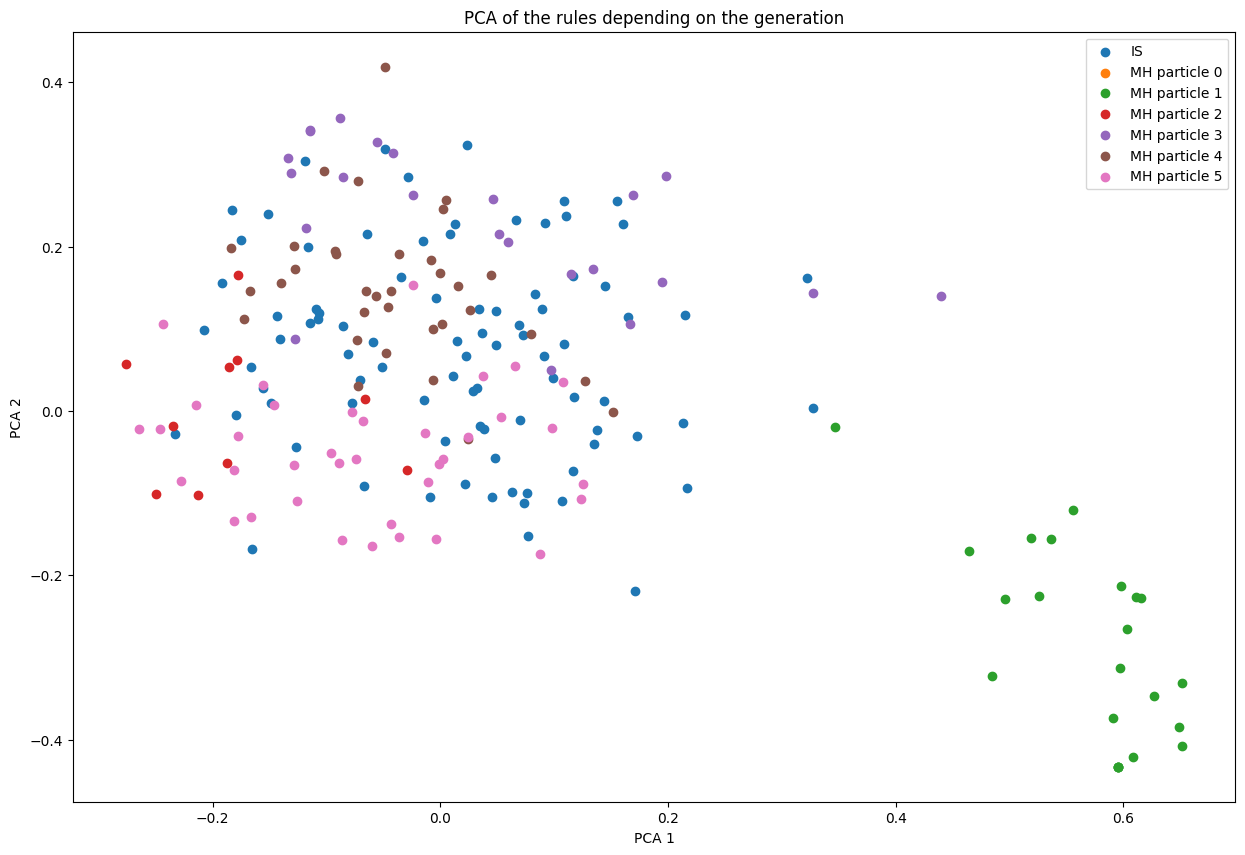

In [33]:
# Plot embeddings with likelihoods high enough
# Plot the embeddings
all_likelihoods = np.concatenate([all_likelihoods_mh.flatten(), all_likelihoods_is.flatten()])
mask_likelihood = all_likelihoods > -400
mask_is = np.arange(len(all_likelihoods)) >= len(all_rules_mh.flatten())
plt.figure(figsize=(15,10))
plt.scatter(proj_embeddings[mask_likelihood&mask_is,0], proj_embeddings[mask_likelihood&mask_is,1], label="IS")
#Plot MH particles
for i in range(len(all_rules_mh)):
    mask_mh = (np.arange(len(all_likelihoods)) < (i+1)*all_rules_mh.shape[1]) & (np.arange(len(all_likelihoods)) >= i*all_rules_mh.shape[1])
    plt.scatter(proj_embeddings[mask_likelihood&mask_mh,0], proj_embeddings[mask_likelihood&mask_mh,1], label="MH particle "+str(i))
plt.legend()
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("PCA of the rules depending on the generation")
plt.show()